In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

import jaxmetric as jm

In [2]:
key = jax.random.PRNGKey(0)

psi=0

poly = lambda x: x[0]**5 + x[1]**5 + x[2]**5 +x[3]**5 + x[4]**5 + psi* x[0]*x[1]*x[2]*x[3]*x[4]

points = np.array([[0.5457718 +0.42877685j, -0.96667378+0.00622714j, -0.2195527-0.23682649j, 0.01382411+0.10245113j, 1.+0.j]])        

In [3]:
'''
pts = genCYnPts(3*10**5,3,poly)


with open("300kPointsPsiEq0.pkl", "wb") as f:
    pickle.dump(pts, f)
'''

with open("100kPointsPsiEq0.pkl", "rb") as f:
    points = pickle.load(f)


print(jnp.shape(points))

(100000, 5)


In [4]:
# Define the model
class FuncQuintic(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=64,param_dtype=jnp.float64)
    self.dense2 = nn.Dense(features=64,param_dtype=jnp.float64)
    self.dense3 = nn.Dense(features=64,param_dtype=jnp.float64)
    self.dense4 = nn.Dense(features=1,use_bias=False,param_dtype=jnp.float64)

  def __call__(self, x):

    xR = x[0]
    xI = x[1]

    kappa = jnp.sum(jnp.square(xR) + jnp.square(xI))

    #xB = x.conj()
    #x = jnp.array([
    #x[0]*xB[0], x[0]*xB[1], x[0]*xB[2], x[0]*xB[3], x[0]*xB[4],
    #x[1]*xB[0], x[1]*xB[1], x[1]*xB[2], x[1]*xB[3], x[1]*xB[4],
    #x[2]*xB[0], x[2]*xB[1], x[2]*xB[2], x[2]*xB[3], x[2]*xB[4],
    #x[3]*xB[0], x[3]*xB[1], x[3]*xB[2], x[3]*xB[3], x[3]*xB[4],
    #x[4]*xB[0], x[4]*xB[1], x[4]*xB[2], x[4]*xB[3], x[4]*xB[4]])/kappa
    
    #x = jnp.array([x.real,x.imag]).flatten()

    x = jnp.array( 
      [
        xR[0]*xR[1] - xI[0]*xI[1], xR[0]*xI[1],
        xR[0]*xR[2] - xI[0]*xI[2], xR[0]*xI[2],
        xR[0]*xR[3] - xI[0]*xI[3], xR[0]*xI[3],
        xR[0]*xR[4] - xI[0]*xI[4], xR[0]*xI[4],
        xR[1]*xR[2] - xI[1]*xI[2], xR[1]*xI[2],
        xR[1]*xR[3] - xI[1]*xI[3], xR[1]*xI[3],
        xR[1]*xR[4] - xI[1]*xI[4], xR[1]*xI[4],
        xR[2]*xR[3] - xI[2]*xI[3], xR[2]*xI[3],
        xR[2]*xR[4] - xI[2]*xI[4], xR[2]*xI[4],
        xR[3]*xR[4] - xI[3]*xI[4], xR[3]*xI[4]

      ])/kappa
    
    x = self.dense1(x)
    x = x**2.
    x = self.dense2(x)
    x = x**2.
    x = self.dense3(x)
    x = x**2.
    x = self.dense4(x)
    return jnp.log(jnp.abs(x[0]))

In [5]:
# Initialize the model
model = FuncQuintic()

# Generate a PRNG key
key = jax.random.PRNGKey(np.random.randint(0,10**6))

# Initialize parameters
params = model.init(key,  jm.complex_numbers.complex_to_real(points[0]))

In [12]:
def replace_nan_grads(gradients, replacement_value=1e-8):
    def replace(grad):
        return jnp.where(jnp.isnan(grad), replacement_value, grad)
    
    return jax.tree_util.tree_map(replace, gradients)

def nan_replacement_transform(replacement_value=1e-6):
    def init_fn(params):
        return ()
    
    def update_fn(updates, state, params=None):
        sanitized_updates = jax.tree_util.tree_map(
            lambda g: jnp.where(jnp.isnan(g), replacement_value, g),
            updates
        )
        return sanitized_updates, state
    
    return optax.GradientTransformation(init_fn, update_fn)

optimiser = optax.chain(
nan_replacement_transform(1e-8),
optax.clip(1.),
#optax.clip_by_block_rms(1e-2),
optax.adam(learning_rate=1e-2)
)

my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

grad_func = jax.jit(jax.value_and_grad(jm.losses.loss_ma,argnums=1),static_argnums=(0,2,4))

# Define the training step
@jax.jit
def train_step(state,x):
  loss, grads = grad_func(model, state.params,(4,),[1], poly, x)
  state = state.apply_gradients(grads=grads)
  return state, loss

@jax.jit
def evaluate_step(state,x):
  return jm.losses.loss_ma(model, state.params,(4,),[1], poly, x)

In [13]:
ptsBatched = jnp.reshape(points,(100,1000,5))

ptsBatched[0].shape

(1000, 5)

In [14]:
evaluate_step(my_state,points)

Array(8.549456e+17, dtype=float32)

In [15]:
# Train the model
eval = evaluate_step(my_state,ptsBatched[-1])
loss = []
lossEval = []
pbar = tqdm(range(10))
batchNum = ptsBatched.shape[0]-1
pbar.set_description(f"Last Eval Loss {eval} | Batch {0}/{batchNum+1}  | Batch Loss: NA")

for i in pbar:
  order = np.array(range(batchNum))[:batchNum]
  np.random.shuffle(order)
  k=1
  for j in order:
    k+=1
    my_state, l = train_step(my_state, ptsBatched[j])
    #if l>1 and i!=0: break
    pbar.set_description(f"Last Eval Loss {eval} | Batch {k}/{batchNum+1}  | Batch Loss: {l}" )
    loss.append(l)
  #if l>1 and i!=0: break
  eval = evaluate_step(my_state,ptsBatched[-1])
  lossEval.append([(i+1)*batchNum,eval])

lossEval = np.array(lossEval)
loss = jnp.array(loss)

Last Eval Loss 0.37199994921684265 | Batch 100/100  | Batch Loss: 0.3469617962837219: 100%|██████████| 10/10 [03:21<00:00, 20.11s/it]


In [16]:
lossEval=jnp.array(lossEval)
loss = jnp.array(loss)

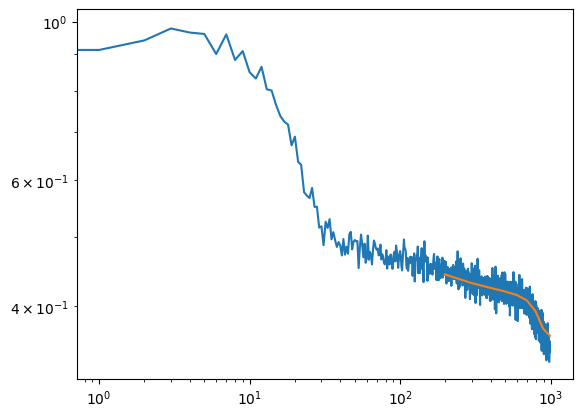

In [18]:
plt.plot((loss[3:]))
plt.plot(lossEval[1:,0],(lossEval[1:,1]))
plt.xscale('log')
plt.yscale('log')
plt.show()